# Sharpe-Based Momentum Strategy with Risk Parity

This notebook implements and analyzes a momentum strategy using 12-month Sharpe ratio ranking with risk parity allocation and monthly rebalancing.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from momentum_strategy import run_full_strategy
from sklearn.linear_model import LinearRegression
from scipy import stats
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)

## Load Data and Run Strategy

In [2]:
# Run the complete momentum strategy
results = run_full_strategy(data_dir='data', lookback_months=12, top_quantile=0.25)

# Extract results
prices = results['prices']
monthly_returns = results['monthly_returns']
momentum_signals = results['momentum_signals']
weights = results['weights']
portfolio_returns = results['portfolio_returns']
portfolio_cumulative = results['portfolio_cumulative']
metrics = results['metrics']

print(f"Sharpe-based momentum strategy with risk parity covers {len(portfolio_returns.dropna())} months")
print(f"Portfolio data from {portfolio_returns.dropna().index[0].strftime('%Y-%m')} to {portfolio_returns.dropna().index[-1].strftime('%Y-%m')}")
print(f"Selection criteria: Top 25% by 12-month Sharpe ratio")
print(f"Allocation method: Risk parity (inverse volatility weighting)")

Loading data...
Calculating monthly returns...
Calculating momentum signals...
Selecting top performers...
Running backtest...
Calculating performance metrics...
Sharpe-based momentum strategy with risk parity covers 308 months
Portfolio data from 2000-01 to 2025-08
Selection criteria: Top 25% by 12-month Sharpe ratio
Allocation method: Risk parity (inverse volatility weighting)


## Data Availability Timeline

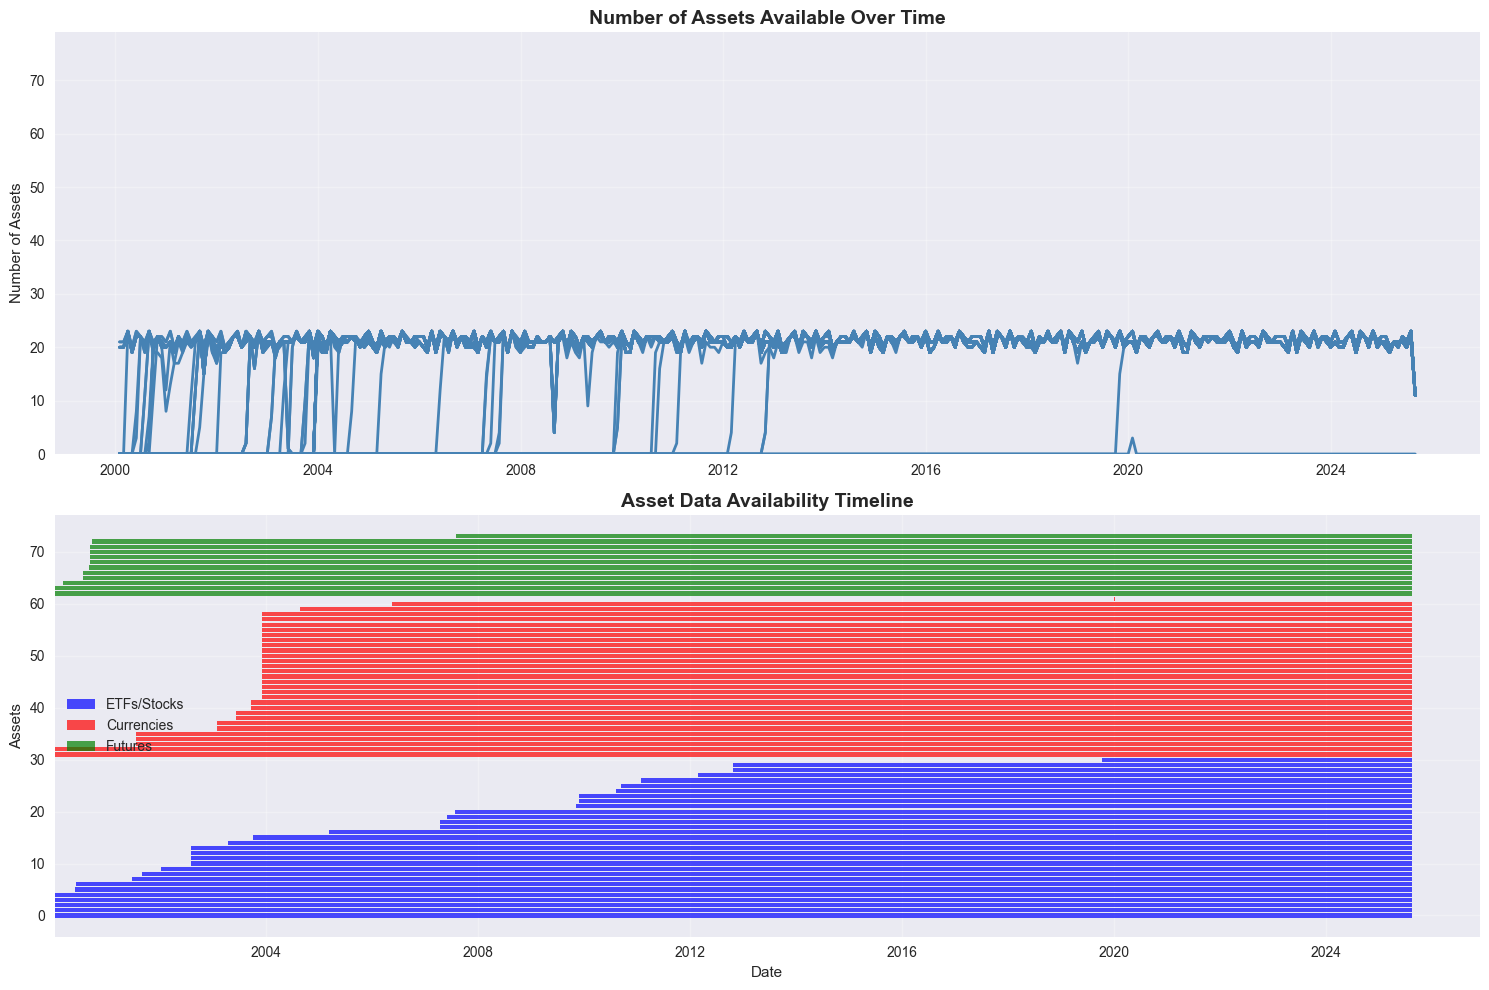

Total assets: 74
Assets by category:
  ETFs/Stocks: 31
  Currencies: 31
  Futures: 12


In [3]:
# Create data availability heatmap
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Data availability over time
data_availability = (~prices.isnull()).astype(int)
data_coverage = data_availability.resample('Y').mean()

# Plot 1: Number of assets available over time
assets_available = data_availability.resample('M').sum()
ax1.plot(assets_available.index, assets_available, linewidth=2, color='steelblue')
ax1.set_title('Number of Assets Available Over Time', fontsize=14, fontweight='bold')
ax1.set_ylabel('Number of Assets')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, len(prices.columns) + 5)

# Plot 2: Asset inception timeline
first_dates = prices.apply(lambda x: x.first_valid_index()).sort_values()
asset_categories = {
    'ETFs/Stocks': [col for col in first_dates.index if not ('_X' in col or '_F' in col)],
    'Currencies': [col for col in first_dates.index if '_X' in col],
    'Futures': [col for col in first_dates.index if '_F' in col]
}

colors = {'ETFs/Stocks': 'blue', 'Currencies': 'red', 'Futures': 'green'}
y_pos = 0

for category, assets in asset_categories.items():
    for asset in assets:
        start_date = first_dates[asset]
        end_date = prices[asset].last_valid_index()
        ax2.barh(y_pos, (end_date - start_date).days, left=start_date, 
                height=0.8, color=colors[category], alpha=0.7, label=category if y_pos == 0 or category != prev_category else "")
        prev_category = category
        y_pos += 1

ax2.set_title('Asset Data Availability Timeline', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Assets')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Total assets: {len(prices.columns)}")
print(f"Assets by category:")
for category, assets in asset_categories.items():
    print(f"  {category}: {len(assets)}")

## Strategy Performance Analysis

In [4]:
# Display performance metrics
print("=" * 70)
print("SHARPE-BASED MOMENTUM + RISK PARITY PERFORMANCE METRICS")
print("=" * 70)

for key, value in metrics.items():
    if isinstance(value, float):
        if 'Return' in key or 'Excess' in key:
            print(f"{key:<25}: {value:.2%}")
        elif 'Ratio' in key:
            print(f"{key:<25}: {value:.3f}")
        elif 'Drawdown' in key:
            print(f"{key:<25}: {value:.2%}")
        elif 'Volatility' in key:
            print(f"{key:<25}: {value:.2%}")
        elif 'Months' in key:
            print(f"{key:<25}: {value:.1%}")
        else:
            print(f"{key:<25}: {value:.4f}")
    else:
        print(f"{key:<25}: {value}")

SHARPE-BASED MOMENTUM + RISK PARITY PERFORMANCE METRICS
Total Return             : 172.77%
Annualized Return        : 3.99%
Volatility               : 5.40%
Sharpe Ratio             : 0.738
Max Drawdown             : -10.41%
Positive Months          : 63.3%
Average Monthly Return   : 0.34%
Best Month               : 0.0703
Worst Month              : -0.0592
Benchmark Total Return   : 627.71%
Benchmark Annualized Return: 8.07%
Benchmark Volatility     : 15.21%
Benchmark Sharpe         : 0.5304
Benchmark Max Drawdown   : -50.78%
Excess Return            : -4.87%
Information Ratio        : -0.337


## Equity Curve Visualization

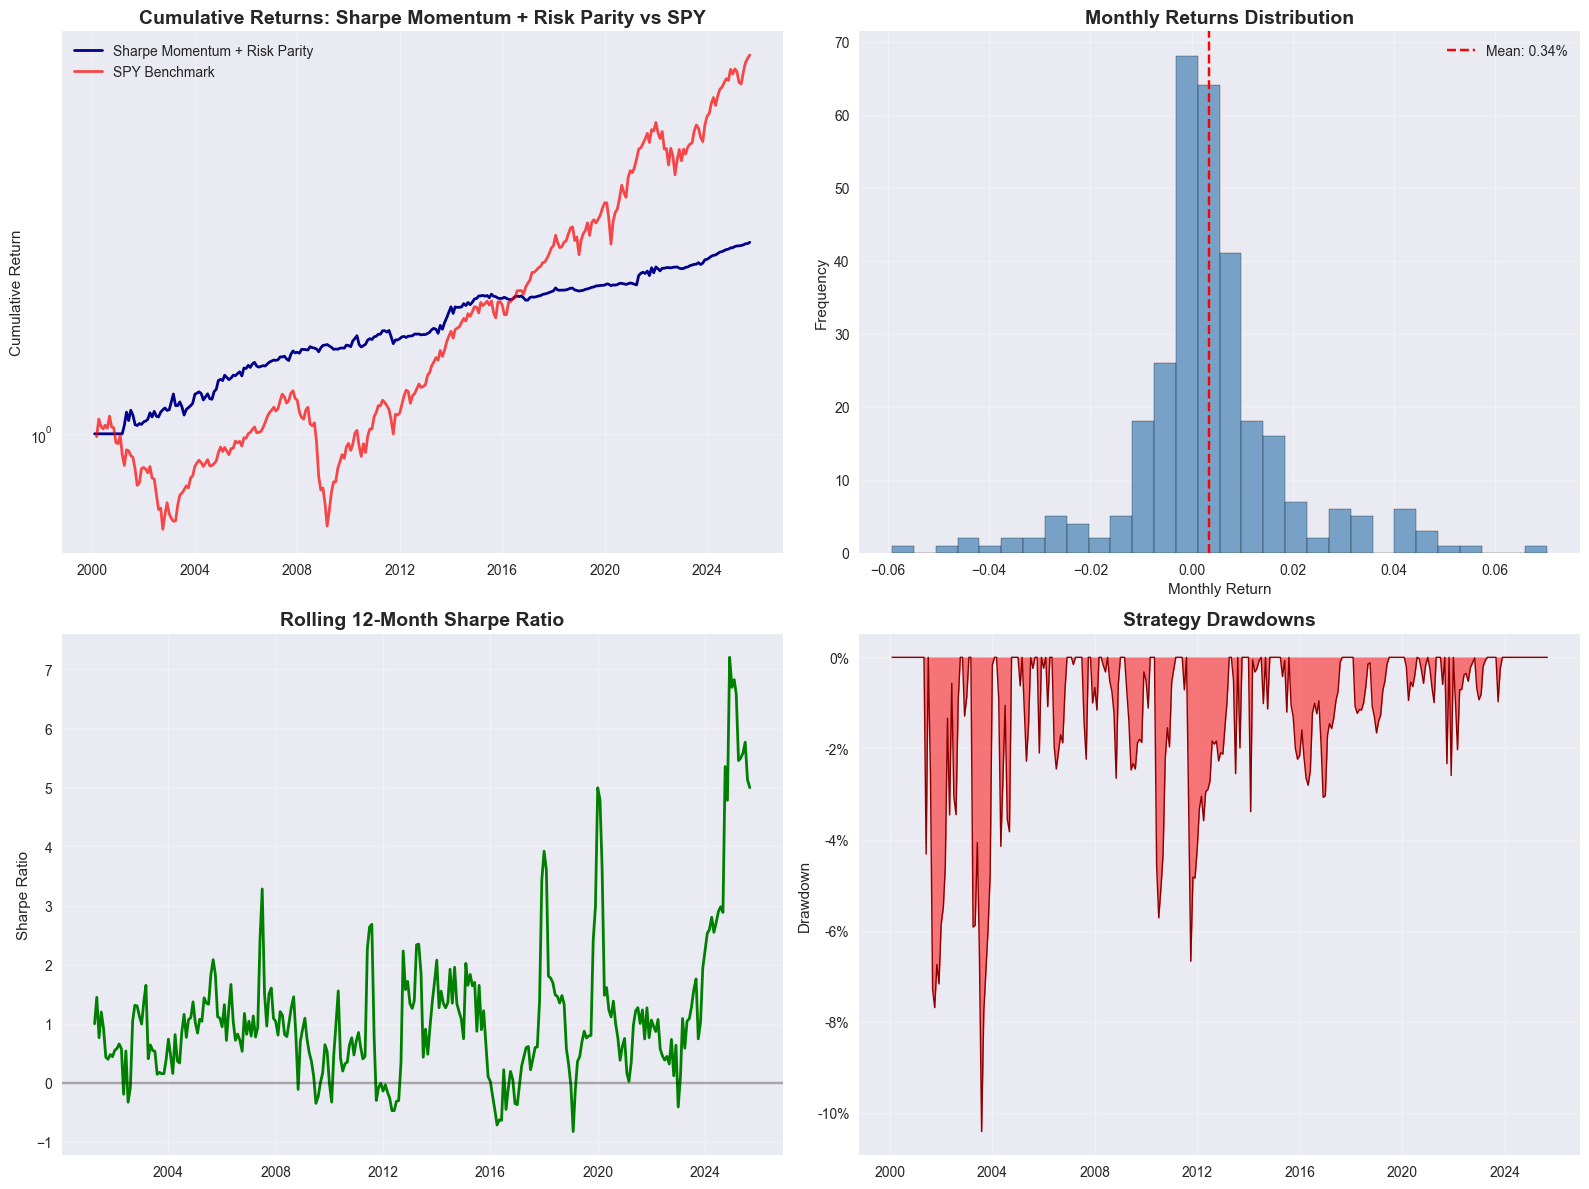

In [5]:
# Plot equity curves
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Cumulative returns comparison
portfolio_clean = portfolio_cumulative.dropna()
ax1.plot(portfolio_clean.index, portfolio_clean, linewidth=2, label='Sharpe Momentum + Risk Parity', color='darkblue')

if 'SPY' in monthly_returns.columns:
    spy_returns = monthly_returns['SPY'].dropna()
    spy_cumulative = (1 + spy_returns).cumprod()
    # Align dates
    common_dates = portfolio_clean.index.intersection(spy_cumulative.index)
    if len(common_dates) > 0:
        ax1.plot(common_dates, spy_cumulative.reindex(common_dates), 
                linewidth=2, label='SPY Benchmark', color='red', alpha=0.7)

ax1.set_title('Cumulative Returns: Sharpe Momentum + Risk Parity vs SPY', fontsize=14, fontweight='bold')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Plot 2: Monthly returns distribution
portfolio_returns_clean = portfolio_returns.dropna()
ax2.hist(portfolio_returns_clean, bins=30, alpha=0.7, color='steelblue', edgecolor='black')
ax2.axvline(portfolio_returns_clean.mean(), color='red', linestyle='--', 
           label=f'Mean: {portfolio_returns_clean.mean():.2%}')
ax2.set_title('Monthly Returns Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Monthly Return')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Rolling Sharpe ratio (12-month)
rolling_sharpe = portfolio_returns_clean.rolling(12).apply(
    lambda x: x.mean() / x.std() * np.sqrt(12) if x.std() > 0 else np.nan
)
ax3.plot(rolling_sharpe.index, rolling_sharpe, linewidth=2, color='green')
ax3.axhline(0, color='black', linestyle='-', alpha=0.3)
ax3.set_title('Rolling 12-Month Sharpe Ratio', fontsize=14, fontweight='bold')
ax3.set_ylabel('Sharpe Ratio')
ax3.grid(True, alpha=0.3)

# Plot 4: Drawdown analysis
cumulative = (1 + portfolio_returns_clean).cumprod()
running_max = cumulative.expanding().max()
drawdowns = (cumulative - running_max) / running_max

ax4.fill_between(drawdowns.index, drawdowns, 0, alpha=0.5, color='red')
ax4.plot(drawdowns.index, drawdowns, linewidth=1, color='darkred')
ax4.set_title('Strategy Drawdowns', fontsize=14, fontweight='bold')
ax4.set_ylabel('Drawdown')
ax4.grid(True, alpha=0.3)
ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.tight_layout()
plt.show()

## Monthly Returns Heatmap

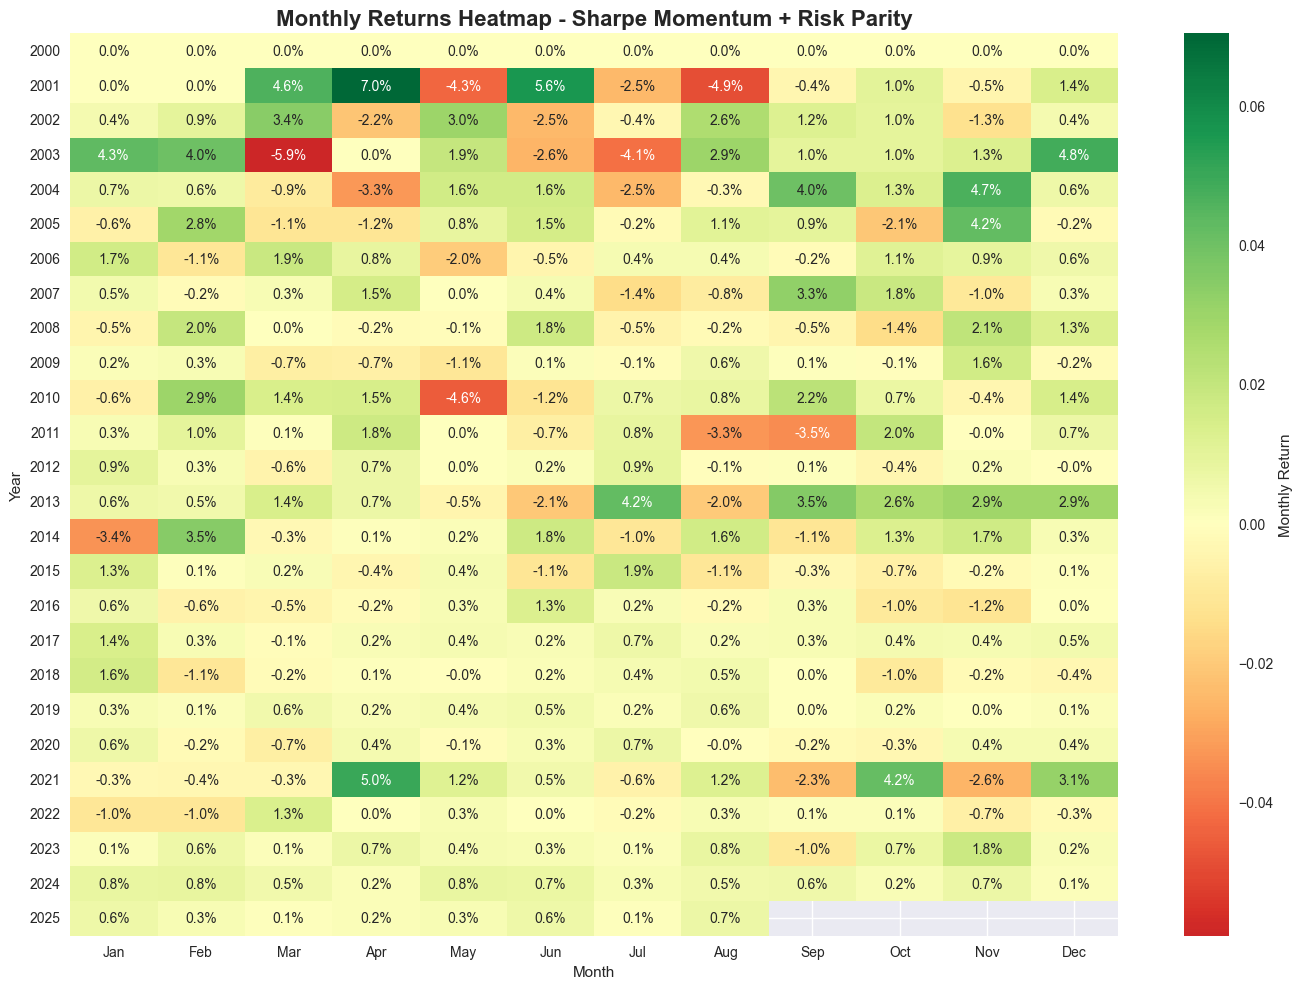


ANNUAL RETURNS:
------------------------------
2000: 0.00%
2001: 6.50%
2002: 6.57%
2003: 8.35%
2004: 8.16%
2005: 5.86%
2006: 4.01%
2007: 4.70%
2008: 3.64%
2009: -0.06%
2010: 4.68%
2011: -0.99%
2012: 2.18%
2013: 15.67%
2014: 4.50%
2015: 0.03%
2016: -0.90%
2017: 4.95%
2018: -0.13%
2019: 3.20%
2020: 1.12%
2021: 8.79%
2022: -0.93%
2023: 5.01%
2024: 6.30%
2025: 2.86%


In [6]:
# Create monthly returns heatmap
portfolio_returns_clean = portfolio_returns.dropna()
monthly_data = portfolio_returns_clean.to_frame('Returns')
monthly_data['Year'] = monthly_data.index.year
monthly_data['Month'] = monthly_data.index.month

# Create pivot table for heatmap
heatmap_data = monthly_data.pivot_table(values='Returns', index='Year', columns='Month')

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, annot=True, fmt='.1%', cmap='RdYlGn', center=0, 
            cbar_kws={'label': 'Monthly Return'}, 
            xticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Monthly Returns Heatmap - Sharpe Momentum + Risk Parity', fontsize=16, fontweight='bold')
plt.ylabel('Year')
plt.xlabel('Month')
plt.tight_layout()
plt.show()

# Calculate annual returns
annual_returns = monthly_data.groupby('Year')['Returns'].apply(lambda x: (1 + x).prod() - 1)
print("\nANNUAL RETURNS:")
print("-" * 30)
for year, ret in annual_returns.items():
    print(f"{year}: {ret:.2%}")

## Risk Parity Allocation Analysis

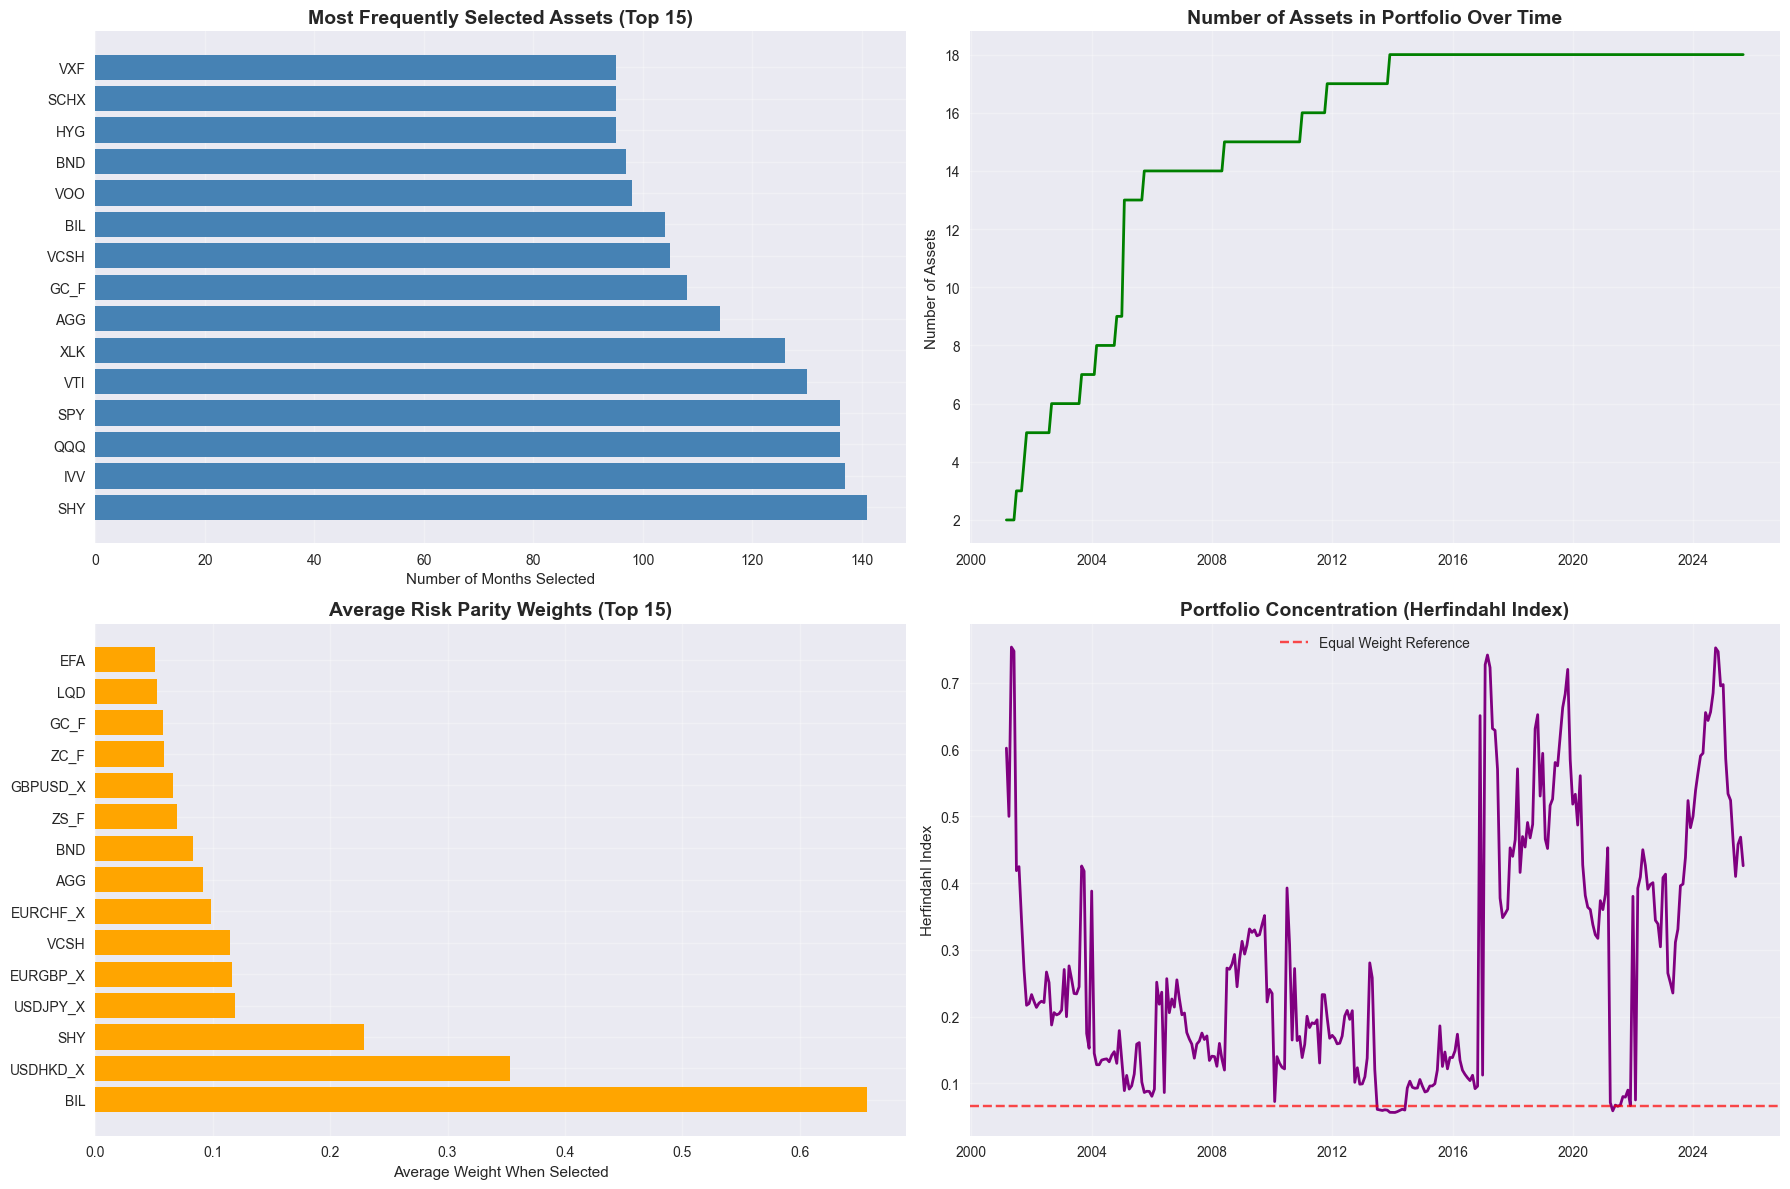


RISK PARITY PORTFOLIO STATISTICS:
Average number of assets held: 15.0
Min assets held: 2
Max assets held: 18
Average Herfindahl index: 0.2817
Total months analyzed: 295


In [7]:
# Analyze risk parity weights over time
weights_clean = weights.loc[weights.sum(axis=1) > 0]

# Count frequency of each asset being selected
selection_frequency = (weights_clean > 0).sum().sort_values(ascending=False)
top_selected = selection_frequency.head(15)

# Calculate average weights for selected assets
avg_weights = weights_clean[weights_clean > 0].mean().sort_values(ascending=False).head(15)

# Plot analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Most frequently selected assets
ax1.barh(range(len(top_selected)), top_selected.values, color='steelblue')
ax1.set_yticks(range(len(top_selected)))
ax1.set_yticklabels(top_selected.index)
ax1.set_xlabel('Number of Months Selected')
ax1.set_title('Most Frequently Selected Assets (Top 15)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: Portfolio concentration over time
portfolio_concentration = weights_clean.apply(lambda row: (row > 0).sum(), axis=1)
ax2.plot(portfolio_concentration.index, portfolio_concentration, linewidth=2, color='green')
ax2.set_title('Number of Assets in Portfolio Over Time', fontsize=14, fontweight='bold')
ax2.set_ylabel('Number of Assets')
ax2.grid(True, alpha=0.3)

# Plot 3: Average risk parity weights
ax3.barh(range(len(avg_weights)), avg_weights.values, color='orange')
ax3.set_yticks(range(len(avg_weights)))
ax3.set_yticklabels(avg_weights.index)
ax3.set_xlabel('Average Weight When Selected')
ax3.set_title('Average Risk Parity Weights (Top 15)', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: Weight concentration (Herfindahl index)
herfindahl = weights_clean.apply(lambda row: (row**2).sum(), axis=1)
ax4.plot(herfindahl.index, herfindahl, linewidth=2, color='purple')
ax4.set_title('Portfolio Concentration (Herfindahl Index)', fontsize=14, fontweight='bold')
ax4.set_ylabel('Herfindahl Index')
ax4.grid(True, alpha=0.3)
equal_weight_line = 1 / portfolio_concentration.mean()
ax4.axhline(equal_weight_line, color='red', linestyle='--', alpha=0.7, label=f'Equal Weight Reference')
ax4.legend()

plt.tight_layout()
plt.show()

print(f"\nRISK PARITY PORTFOLIO STATISTICS:")
print(f"Average number of assets held: {portfolio_concentration.mean():.1f}")
print(f"Min assets held: {portfolio_concentration.min()}")
print(f"Max assets held: {portfolio_concentration.max()}")
print(f"Average Herfindahl index: {herfindahl.mean():.4f}")
print(f"Total months analyzed: {len(weights_clean)}")

## Risk Contribution Analysis

Calculating risk contributions...


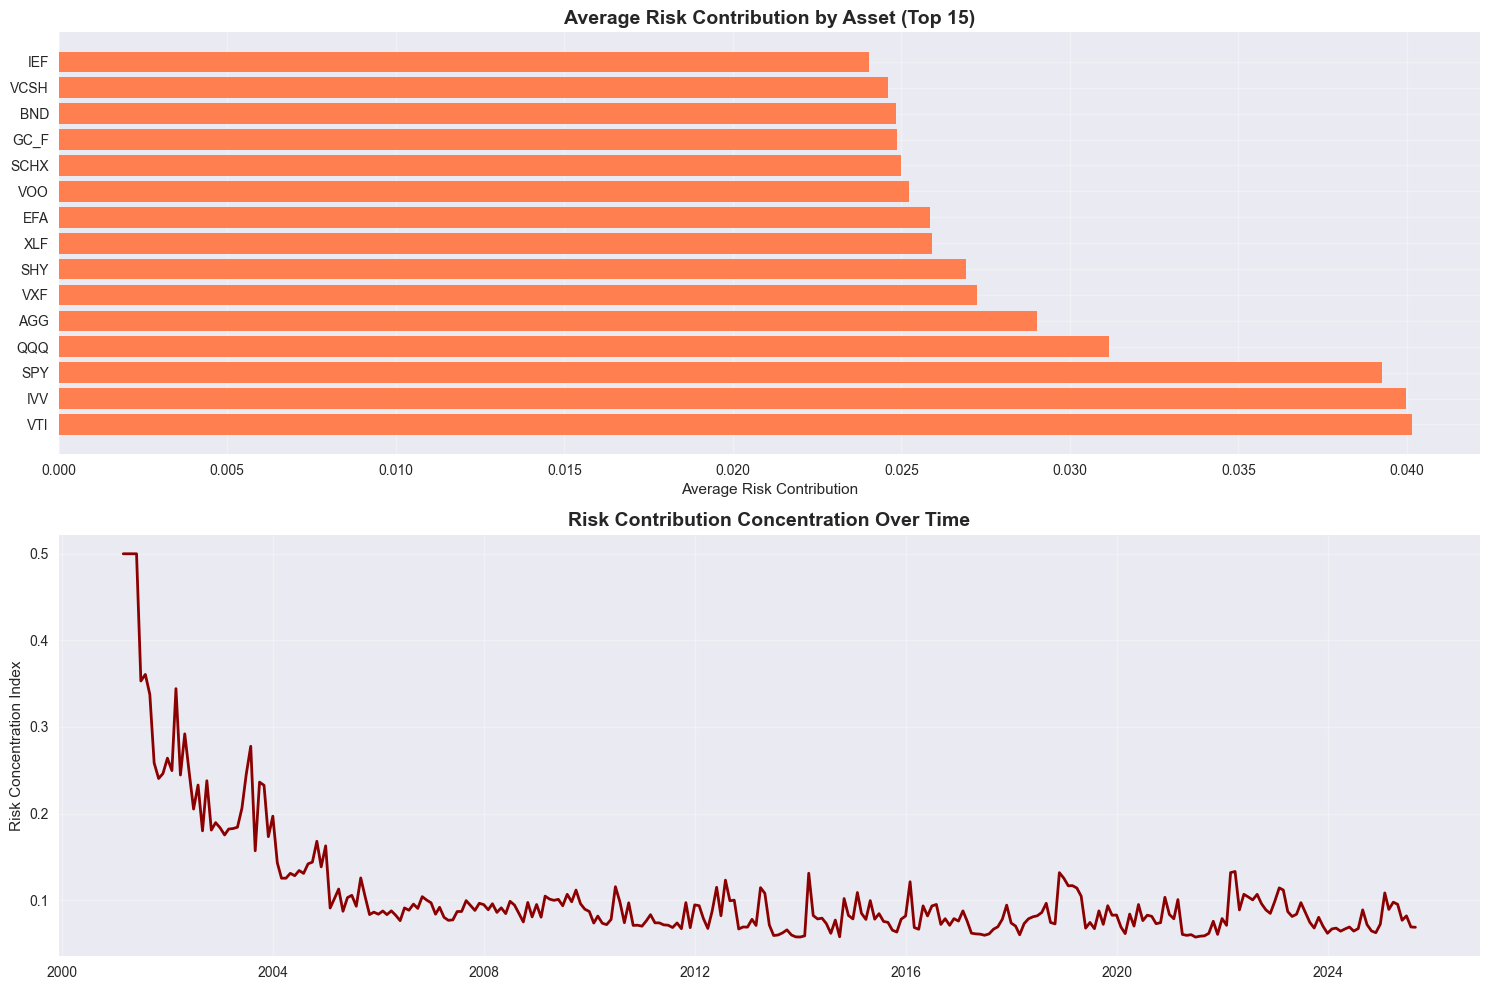


RISK CONTRIBUTION ANALYSIS:
Average risk concentration: 0.1075
Risk parity effectiveness: 89.2%


In [8]:
# Analyze risk contributions over time
def calculate_risk_contributions(weights, returns, lookback=12):
    """Calculate risk contributions for portfolio holdings."""
    risk_contribs = []
    
    for date in weights.index:
        if weights.loc[date].sum() > 0:
            # Get portfolio weights
            w = weights.loc[date][weights.loc[date] > 0]
            
            # Get historical returns for calculation period
            end_idx = returns.index.get_loc(date)
            start_idx = max(0, end_idx - lookback)
            hist_returns = returns.iloc[start_idx:end_idx+1][w.index]
            
            if len(hist_returns) > 1:
                # Calculate covariance matrix
                cov_matrix = hist_returns.cov() * 12  # Annualized
                
                # Calculate portfolio variance
                portfolio_var = w.T @ cov_matrix @ w
                
                # Calculate marginal risk contributions
                if portfolio_var > 0:
                    marginal_contrib = cov_matrix @ w
                    risk_contrib = w * marginal_contrib / portfolio_var
                    
                    risk_contribs.append(pd.Series(risk_contrib, name=date))
    
    if risk_contribs:
        return pd.DataFrame(risk_contribs).fillna(0)
    else:
        return pd.DataFrame()

# Calculate risk contributions
print("Calculating risk contributions...")
risk_contributions = calculate_risk_contributions(weights_clean, monthly_returns)

if not risk_contributions.empty:
    # Plot risk contribution evolution
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot 1: Average risk contribution by asset
    avg_risk_contrib = risk_contributions.mean().sort_values(ascending=False).head(15)
    ax1.barh(range(len(avg_risk_contrib)), avg_risk_contrib.values, color='coral')
    ax1.set_yticks(range(len(avg_risk_contrib)))
    ax1.set_yticklabels(avg_risk_contrib.index)
    ax1.set_xlabel('Average Risk Contribution')
    ax1.set_title('Average Risk Contribution by Asset (Top 15)', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Risk contribution concentration over time
    risk_concentration = risk_contributions.apply(lambda row: (row**2).sum(), axis=1)
    ax2.plot(risk_concentration.index, risk_concentration, linewidth=2, color='darkred')
    ax2.set_title('Risk Contribution Concentration Over Time', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Risk Concentration Index')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nRISK CONTRIBUTION ANALYSIS:")
    print(f"Average risk concentration: {risk_concentration.mean():.4f}")
    print(f"Risk parity effectiveness: {(1 - risk_concentration.mean()) * 100:.1f}%")
else:
    print("Could not calculate risk contributions - insufficient data")

## Summary Statistics

In [9]:
# Final summary table
print("=" * 80)
print("SHARPE-BASED MOMENTUM + RISK PARITY STRATEGY SUMMARY")
print("=" * 80)
print(f"Strategy Period: {portfolio_returns.dropna().index[0].strftime('%B %Y')} to {portfolio_returns.dropna().index[-1].strftime('%B %Y')}")
print(f"Total Months: {len(portfolio_returns.dropna())}")
print(f"Selection Metric: 12-month Sharpe ratio")
print(f"Top Quantile: 25%")
print(f"Allocation Method: Risk parity (inverse volatility)")
print(f"Rebalancing: Monthly")
print(f"Universe Size: {len(prices.columns)} assets")
print()
print("KEY PERFORMANCE METRICS:")
print(f"Total Return: {metrics['Total Return']:.2%}")
print(f"Annualized Return: {metrics['Annualized Return']:.2%}")
print(f"Volatility: {metrics['Volatility']:.2%}")
print(f"Sharpe Ratio: {metrics['Sharpe Ratio']:.3f}")
print(f"Maximum Drawdown: {metrics['Max Drawdown']:.2%}")
print(f"Positive Months: {metrics['Positive Months']:.1%}")

if 'Benchmark Total Return' in metrics:
    print()
    print("vs SPY BENCHMARK:")
    print(f"Excess Return: {metrics['Excess Return']:.2%}")
    print(f"Information Ratio: {metrics['Information Ratio']:.3f}")

print()
print("STRATEGY FEATURES:")
print("✓ Sharpe ratio-based momentum (risk-adjusted returns)")
print("✓ Risk parity allocation (inverse volatility weighting)")
print("✓ No look-ahead bias (proper signal shifting)")
print("✓ Monthly rebalancing with 12-month lookback")
print("✓ Multi-asset universe (equities, bonds, currencies, commodities)")

SHARPE-BASED MOMENTUM + RISK PARITY STRATEGY SUMMARY
Strategy Period: January 2000 to August 2025
Total Months: 308
Selection Metric: 12-month Sharpe ratio
Top Quantile: 25%
Allocation Method: Risk parity (inverse volatility)
Rebalancing: Monthly
Universe Size: 74 assets

KEY PERFORMANCE METRICS:
Total Return: 172.77%
Annualized Return: 3.99%
Volatility: 5.40%
Sharpe Ratio: 0.738
Maximum Drawdown: -10.41%
Positive Months: 63.3%

vs SPY BENCHMARK:
Excess Return: -4.87%
Information Ratio: -0.337

STRATEGY FEATURES:
✓ Sharpe ratio-based momentum (risk-adjusted returns)
✓ Risk parity allocation (inverse volatility weighting)
✓ No look-ahead bias (proper signal shifting)
✓ Monthly rebalancing with 12-month lookback
✓ Multi-asset universe (equities, bonds, currencies, commodities)


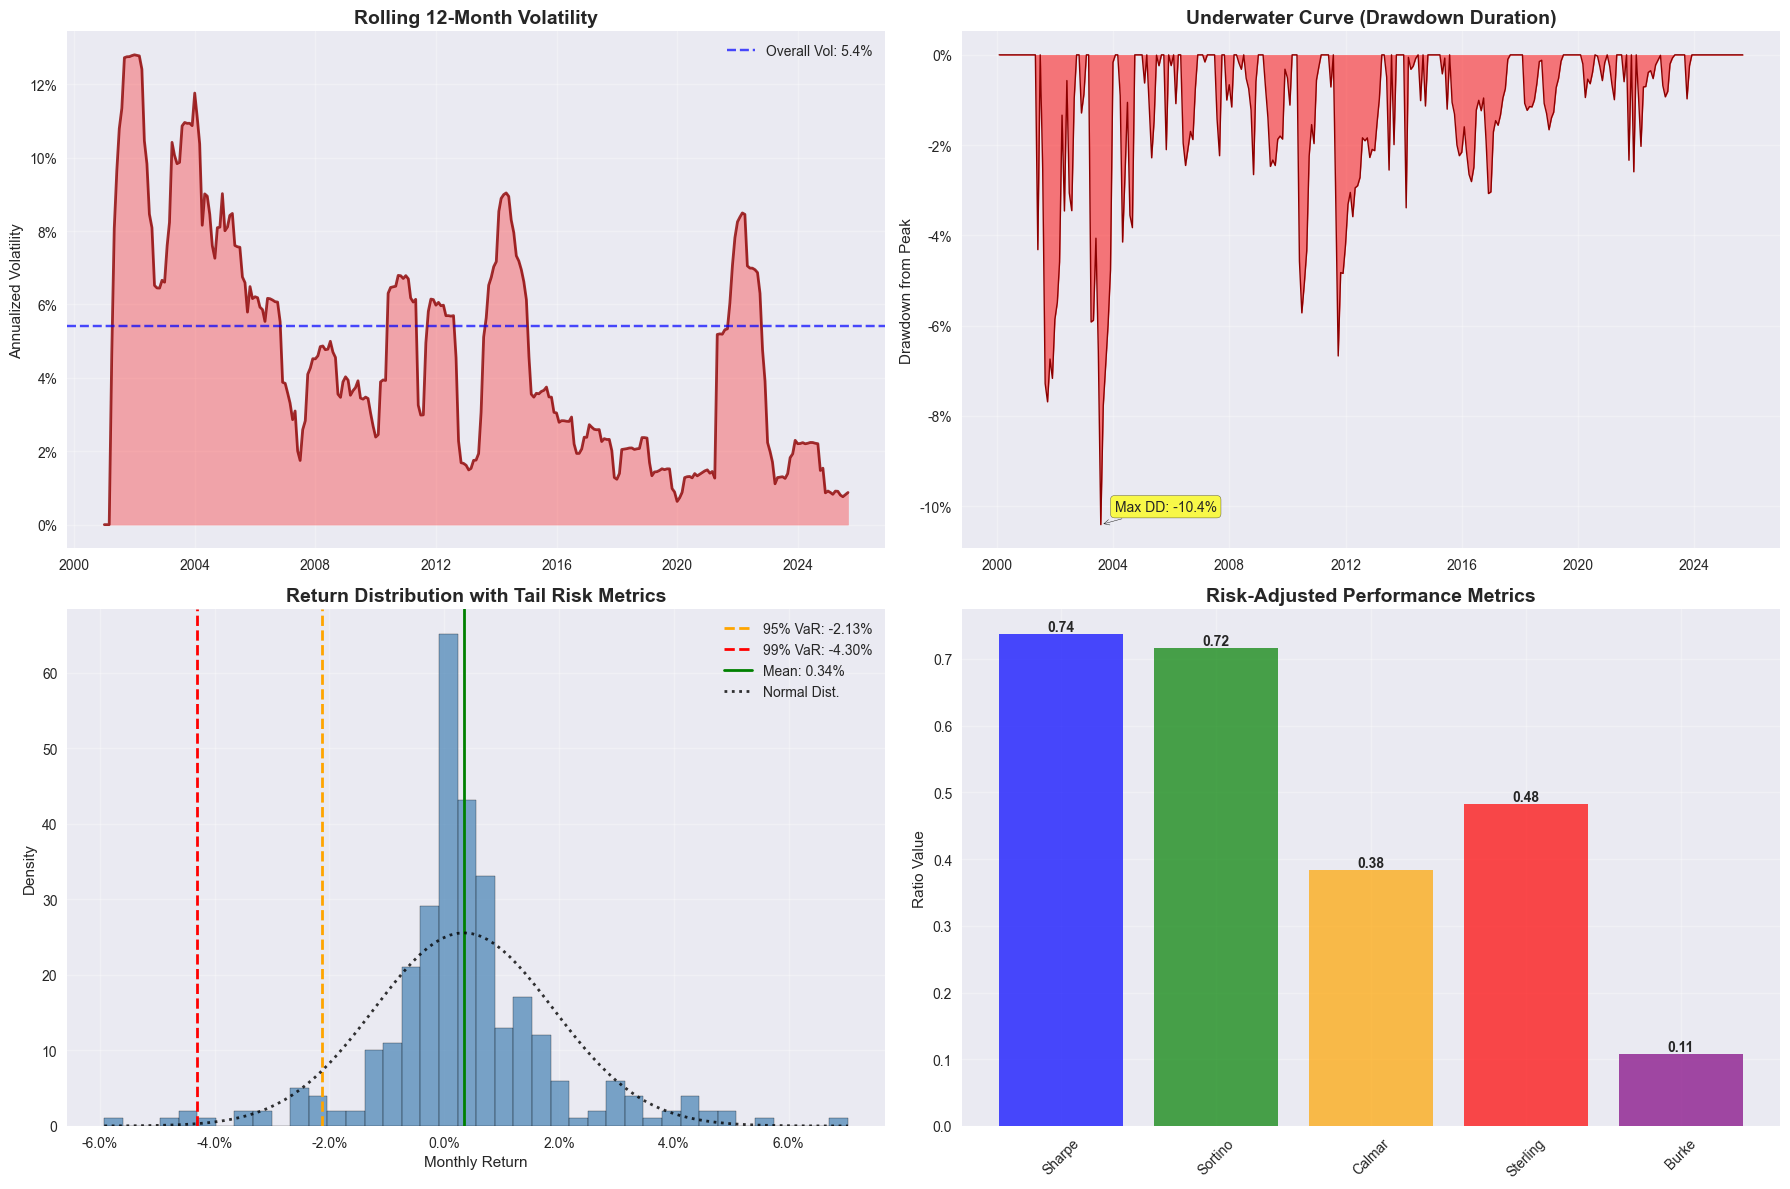

COMPREHENSIVE EQUITY CURVE STATISTICS:

RISK-ADJUSTED METRICS:
----------------------------------------
Sharpe Ratio        : 0.738
Sortino Ratio       : 0.716
Calmar Ratio        : 0.383
Sterling Ratio      : 0.483
Burke Ratio         : 0.108

TAIL RISK METRICS:
----------------------------------------
VaR 95%             : -2.13%
VaR 99%             : -4.30%
CVaR 95%            : -3.41%
CVaR 99%            : -4.93%
Downside Deviation  : 5.57%

CONSISTENCY METRICS:
----------------------------------------
Win Rate            : 63.3%
Gain-to-Pain Ratio  : 1.98
Profit Factor       : 1.98
Win/Loss Ratio      : 1.01
Average Win         : 1.08%
Average Loss        : -1.07%

VOLATILITY METRICS:
----------------------------------------
Overall Volatility  : 5.40%
Rolling Vol Mean    : 4.71%
Rolling Vol Std     : 3.10%
Rolling Vol Min     : 0.00%
Rolling Vol Max     : 12.80%

DRAWDOWN ANALYSIS:
----------------------------------------
Maximum Drawdown: -10.41%
Average Drawdown: -1.96%
Drawdow

In [10]:
# === ADDITIONAL EQUITY CURVE STATISTICS ===
portfolio_returns_clean = portfolio_returns.dropna()
portfolio_cumulative_clean = portfolio_cumulative.dropna()

# Calculate additional metrics
def calculate_calmar_ratio(returns, drawdowns):
    """Calculate Calmar ratio (annual return / max drawdown)"""
    annual_return = (1 + returns).prod() ** (12 / len(returns)) - 1
    max_dd = abs(drawdowns.min())
    return annual_return / max_dd if max_dd > 0 else np.inf

def calculate_sterling_ratio(returns, drawdowns):
    """Calculate Sterling ratio using average of largest drawdowns"""
    annual_return = (1 + returns).prod() ** (12 / len(returns)) - 1
    # Find all drawdown periods
    dd_periods = []
    in_drawdown = False
    start_dd = None
    
    for i, dd in enumerate(drawdowns):
        if dd < -0.01 and not in_drawdown:  # Start of drawdown (>1%)
            in_drawdown = True
            start_dd = i
        elif dd >= -0.01 and in_drawdown:  # End of drawdown
            in_drawdown = False
            if start_dd is not None:
                dd_periods.append(abs(drawdowns[start_dd:i+1].min()))
    
    if len(dd_periods) >= 3:
        avg_top3_dd = np.mean(sorted(dd_periods, reverse=True)[:3])
        return annual_return / avg_top3_dd if avg_top3_dd > 0 else np.inf
    else:
        return calculate_calmar_ratio(returns, drawdowns)

def calculate_burke_ratio(returns, drawdowns):
    """Calculate Burke ratio"""
    annual_return = (1 + returns).prod() ** (12 / len(returns)) - 1
    burke_dd = np.sqrt(np.sum(drawdowns[drawdowns < 0] ** 2))
    return annual_return / burke_dd if burke_dd > 0 else np.inf

# Calculate drawdowns
cumulative = (1 + portfolio_returns_clean).cumprod()
running_max = cumulative.expanding().max()
drawdowns = (cumulative - running_max) / running_max

# Calculate additional risk-adjusted metrics
calmar = calculate_calmar_ratio(portfolio_returns_clean, drawdowns)
sterling = calculate_sterling_ratio(portfolio_returns_clean, drawdowns)
burke = calculate_burke_ratio(portfolio_returns_clean, drawdowns)

# Calculate downside metrics
downside_returns = portfolio_returns_clean[portfolio_returns_clean < 0]
downside_deviation = np.sqrt(np.mean(downside_returns ** 2)) * np.sqrt(12)
sortino_ratio = metrics['Annualized Return'] / downside_deviation if downside_deviation > 0 else np.inf

# Calculate tail risk metrics
var_95 = np.percentile(portfolio_returns_clean, 5)
var_99 = np.percentile(portfolio_returns_clean, 1)
cvar_95 = portfolio_returns_clean[portfolio_returns_clean <= var_95].mean()
cvar_99 = portfolio_returns_clean[portfolio_returns_clean <= var_99].mean()

# Rolling volatility analysis
rolling_vol = portfolio_returns_clean.rolling(12).std() * np.sqrt(12)

# Consistency metrics
def calculate_consistency_metrics(returns):
    """Calculate various consistency metrics"""
    # Gain-to-pain ratio
    positive_returns = returns[returns > 0].sum()
    negative_returns = abs(returns[returns < 0].sum())
    gain_to_pain = positive_returns / negative_returns if negative_returns > 0 else np.inf
    
    # Win rate
    win_rate = (returns > 0).mean()
    
    # Average win/loss ratio
    avg_win = returns[returns > 0].mean() if (returns > 0).any() else 0
    avg_loss = returns[returns < 0].mean() if (returns < 0).any() else 0
    win_loss_ratio = abs(avg_win / avg_loss) if avg_loss < 0 else np.inf
    
    # Profit factor
    profit_factor = positive_returns / abs(negative_returns) if negative_returns > 0 else np.inf
    
    return {
        'gain_to_pain': gain_to_pain,
        'win_rate': win_rate,
        'win_loss_ratio': win_loss_ratio,
        'profit_factor': profit_factor,
        'avg_win': avg_win,
        'avg_loss': avg_loss
    }

consistency_metrics = calculate_consistency_metrics(portfolio_returns_clean)

# Create comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Rolling volatility analysis
ax1.plot(rolling_vol.index, rolling_vol, linewidth=2, color='darkred', alpha=0.8)
ax1.axhline(metrics['Volatility'], color='blue', linestyle='--', alpha=0.7, 
           label=f"Overall Vol: {metrics['Volatility']:.1%}")
ax1.fill_between(rolling_vol.index, rolling_vol, alpha=0.3, color='red')
ax1.set_title('Rolling 12-Month Volatility', fontsize=14, fontweight='bold')
ax1.set_ylabel('Annualized Volatility')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Plot 2: Underwater curve (drawdown duration)
ax2.fill_between(drawdowns.index, drawdowns, 0, alpha=0.5, color='red')
ax2.plot(drawdowns.index, drawdowns, linewidth=1, color='darkred')
ax2.set_title('Underwater Curve (Drawdown Duration)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Drawdown from Peak')
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Add drawdown recovery annotations
major_dds = drawdowns[drawdowns < -0.05]  # Drawdowns > 5%
if len(major_dds) > 0:
    max_dd_date = drawdowns.idxmin()
    ax2.annotate(f'Max DD: {drawdowns.min():.1%}', 
                xy=(max_dd_date, drawdowns.min()), 
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Plot 3: Return distribution with tail risk
ax3.hist(portfolio_returns_clean, bins=40, alpha=0.7, color='steelblue', 
         edgecolor='black', density=True)
ax3.axvline(var_95, color='orange', linestyle='--', linewidth=2, 
           label=f'95% VaR: {var_95:.2%}')
ax3.axvline(var_99, color='red', linestyle='--', linewidth=2, 
           label=f'99% VaR: {var_99:.2%}')
ax3.axvline(portfolio_returns_clean.mean(), color='green', linestyle='-', linewidth=2, 
           label=f'Mean: {portfolio_returns_clean.mean():.2%}')

# Add normal distribution overlay
x_norm = np.linspace(portfolio_returns_clean.min(), portfolio_returns_clean.max(), 100)
y_norm = stats.norm.pdf(x_norm, portfolio_returns_clean.mean(), portfolio_returns_clean.std())
ax3.plot(x_norm, y_norm, 'black', linewidth=2, linestyle=':', alpha=0.8, label='Normal Dist.')

ax3.set_title('Return Distribution with Tail Risk Metrics', fontsize=14, fontweight='bold')
ax3.set_xlabel('Monthly Return')
ax3.set_ylabel('Density')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

# Plot 4: Risk-adjusted metrics comparison
risk_metrics = {
    'Sharpe': metrics['Sharpe Ratio'],
    'Sortino': sortino_ratio,
    'Calmar': calmar,
    'Sterling': sterling,
    'Burke': burke
}

# Cap extreme values for visualization
capped_metrics = {k: min(v, 5.0) for k, v in risk_metrics.items()}

bars = ax4.bar(range(len(capped_metrics)), list(capped_metrics.values()), 
               color=['blue', 'green', 'orange', 'red', 'purple'], alpha=0.7)
ax4.set_xticks(range(len(capped_metrics)))
ax4.set_xticklabels(list(capped_metrics.keys()), rotation=45)
ax4.set_title('Risk-Adjusted Performance Metrics', fontsize=14, fontweight='bold')
ax4.set_ylabel('Ratio Value')
ax4.grid(True, alpha=0.3)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, risk_metrics.values())):
    height = bar.get_height()
    label = f'{value:.2f}' if value < 10 else f'{value:.1f}'
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             label, ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print comprehensive statistics table
print("COMPREHENSIVE EQUITY CURVE STATISTICS:")
print("=" * 80)

additional_stats = {
    'RISK-ADJUSTED METRICS': {
        'Sharpe Ratio': f"{metrics['Sharpe Ratio']:.3f}",
        'Sortino Ratio': f"{sortino_ratio:.3f}",
        'Calmar Ratio': f"{calmar:.3f}",
        'Sterling Ratio': f"{sterling:.3f}",
        'Burke Ratio': f"{burke:.3f}",
    },
    'TAIL RISK METRICS': {
        'VaR 95%': f"{var_95:.2%}",
        'VaR 99%': f"{var_99:.2%}",
        'CVaR 95%': f"{cvar_95:.2%}",
        'CVaR 99%': f"{cvar_99:.2%}",
        'Downside Deviation': f"{downside_deviation:.2%}",
    },
    'CONSISTENCY METRICS': {
        'Win Rate': f"{consistency_metrics['win_rate']:.1%}",
        'Gain-to-Pain Ratio': f"{consistency_metrics['gain_to_pain']:.2f}",
        'Profit Factor': f"{consistency_metrics['profit_factor']:.2f}",
        'Win/Loss Ratio': f"{consistency_metrics['win_loss_ratio']:.2f}",
        'Average Win': f"{consistency_metrics['avg_win']:.2%}",
        'Average Loss': f"{consistency_metrics['avg_loss']:.2%}",
    },
    'VOLATILITY METRICS': {
        'Overall Volatility': f"{metrics['Volatility']:.2%}",
        'Rolling Vol Mean': f"{rolling_vol.mean():.2%}",
        'Rolling Vol Std': f"{rolling_vol.std():.2%}",
        'Rolling Vol Min': f"{rolling_vol.min():.2%}",
        'Rolling Vol Max': f"{rolling_vol.max():.2%}",
    }
}

for category, stats_dict in additional_stats.items():
    print(f"\n{category}:")
    print("-" * 40)
    for stat, value in stats_dict.items():
        print(f"{stat:<20}: {value}")

# Drawdown analysis
print(f"\nDRAWDOWN ANALYSIS:")
print("-" * 40)
print(f"Maximum Drawdown: {metrics['Max Drawdown']:.2%}")
print(f"Average Drawdown: {drawdowns[drawdowns < 0].mean():.2%}")
print(f"Drawdown Periods > 5%: {(drawdowns < -0.05).sum()}")
print(f"Time in Drawdown: {(drawdowns < -0.01).mean():.1%}")

# Calculate longest drawdown period
dd_lengths = []
current_length = 0
for dd in drawdowns:
    if dd < -0.01:
        current_length += 1
    else:
        if current_length > 0:
            dd_lengths.append(current_length)
        current_length = 0

if dd_lengths:
    print(f"Longest Drawdown Period: {max(dd_lengths)} months")
    print(f"Average Drawdown Period: {np.mean(dd_lengths):.1f} months")

## Additional Equity Curve Statistics

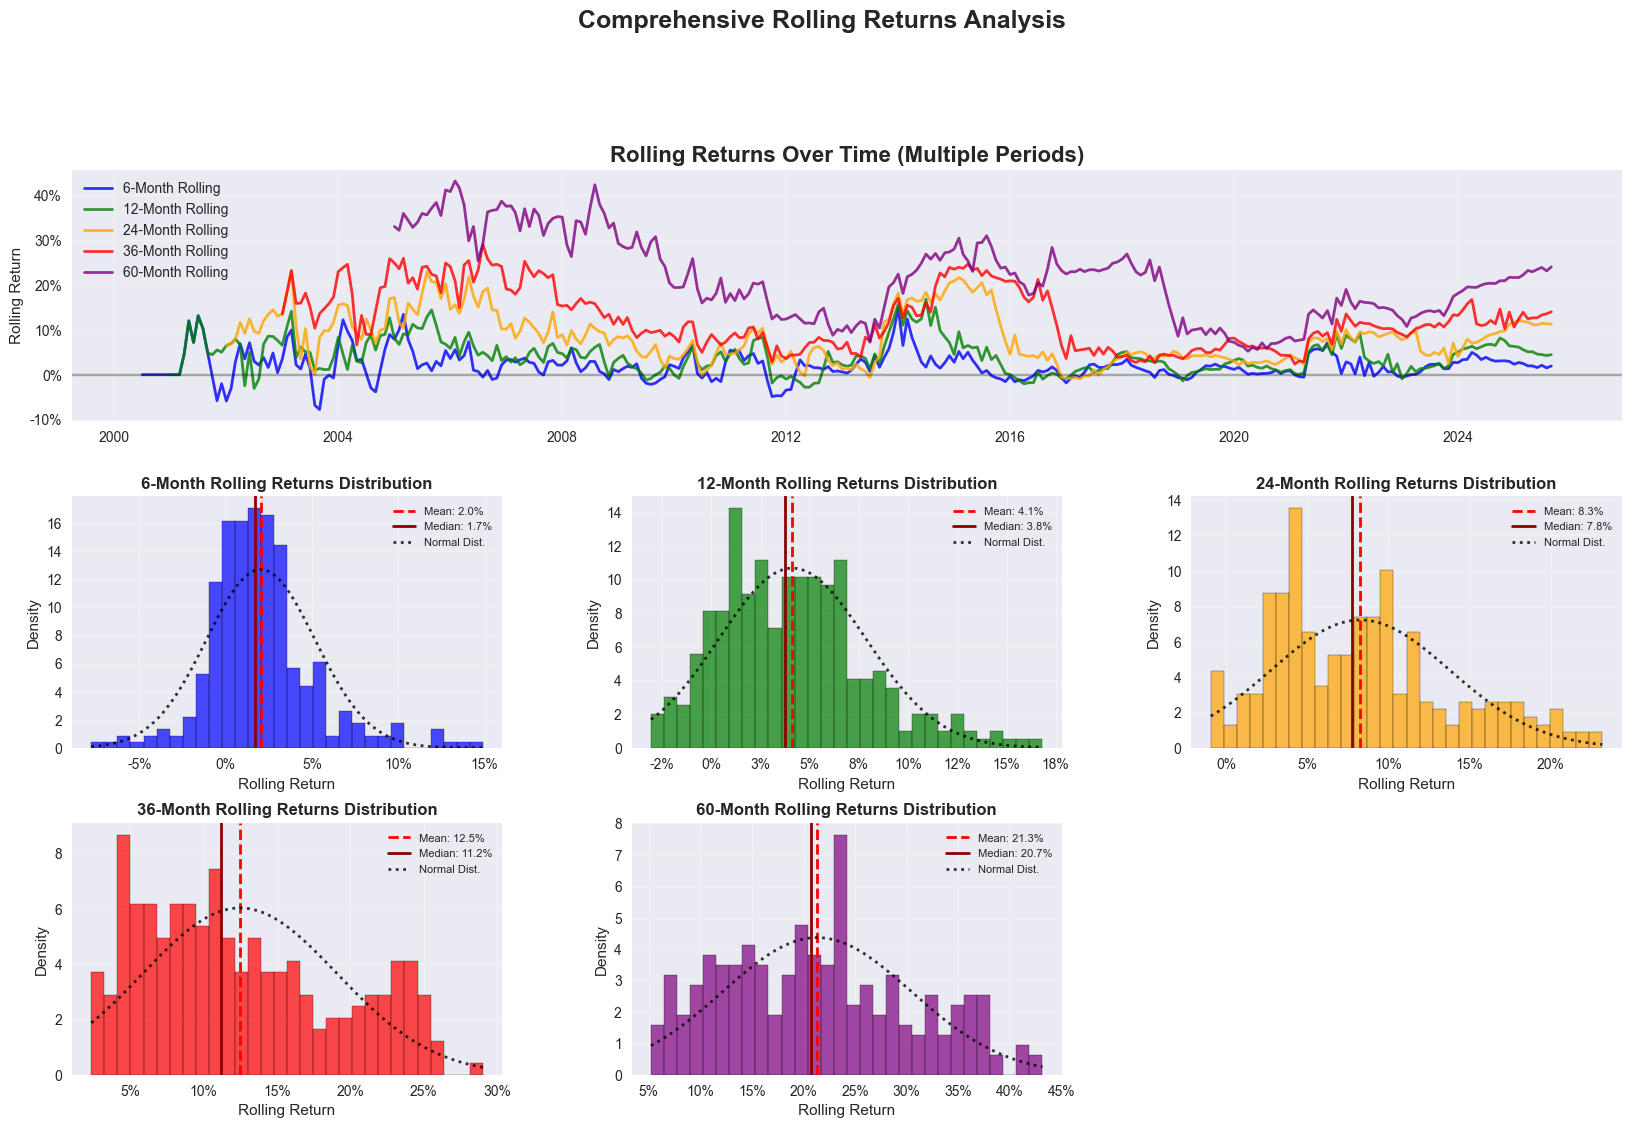

ROLLING RETURNS STATISTICS:
Period   Mean Median Std Dev    Min    Max Skewness Kurtosis Positive %  Count
    6M  2.03%  1.71%   3.14% -7.78% 14.89%    0.860    2.692      76.6%    303
   12M  4.12%  3.76%   3.74% -3.06% 16.82%    0.688    0.428      87.5%    297
   24M  8.28%  7.77%   5.52% -0.94% 23.18%    0.643   -0.267      96.1%    285
   36M 12.48% 11.19%   6.62%  2.36% 29.02%    0.488   -0.871     100.0%    273
   60M 21.31% 20.73%   9.14%  5.21% 43.15%    0.301   -0.741     100.0%    249

ROLLING RETURNS CORRELATION MATRIX:
        6M    12M    24M    36M    60M
6M   1.000  0.580  0.448  0.358  0.231
12M  0.580  1.000  0.700  0.487  0.405
24M  0.448  0.700  1.000  0.784  0.591
36M  0.358  0.487  0.784  1.000  0.712
60M  0.231  0.405  0.591  0.712  1.000

ANNUALIZED SHARPE RATIOS (Rolling Periods):
 6-Month Rolling: 2.236
12-Month Rolling: 3.873
24-Month Rolling: 5.382
36-Month Rolling: 6.893
60-Month Rolling: 8.793

ROLLING RETURNS HIT RATES:

6-Month Rolling Returns:
  > 0%: 

In [11]:
# === ROLLING RETURNS ANALYSIS ===
portfolio_returns_clean = portfolio_returns.dropna()

# Calculate rolling returns for different periods
rolling_periods = [6, 12, 24, 36, 60]  # months
rolling_returns_data = {}

for period in rolling_periods:
    if len(portfolio_returns_clean) >= period:
        rolling_ret = portfolio_returns_clean.rolling(period).apply(
            lambda x: (1 + x).prod() - 1
        )
        rolling_returns_data[f'{period}M'] = rolling_ret

# Convert to DataFrame for easier plotting
rolling_df = pd.DataFrame(rolling_returns_data)

# Create comprehensive rolling returns visualization
fig = plt.figure(figsize=(20, 16))

# Create a grid layout
gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)

# Plot 1: Rolling returns over time (multiple periods)
ax1 = fig.add_subplot(gs[0, :])
colors = ['blue', 'green', 'orange', 'red', 'purple']
for i, (period, color) in enumerate(zip(rolling_periods, colors)):
    if f'{period}M' in rolling_df.columns:
        ax1.plot(rolling_df.index, rolling_df[f'{period}M'], 
                linewidth=2, label=f'{period}-Month Rolling', color=color, alpha=0.8)

ax1.axhline(0, color='black', linestyle='-', alpha=0.3)
ax1.set_title('Rolling Returns Over Time (Multiple Periods)', fontsize=16, fontweight='bold')
ax1.set_ylabel('Rolling Return')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Plots 2-6: Individual rolling return distributions
for i, period in enumerate(rolling_periods):
    if f'{period}M' in rolling_df.columns:
        ax = fig.add_subplot(gs[1 + i//3, i%3])
        
        data = rolling_df[f'{period}M'].dropna()
        
        # Histogram
        ax.hist(data, bins=30, alpha=0.7, color=colors[i], edgecolor='black', density=True)
        
        # Add statistics lines
        mean_val = data.mean()
        median_val = data.median()
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, 
                  label=f'Mean: {mean_val:.1%}')
        ax.axvline(median_val, color='darkred', linestyle='-', linewidth=2, 
                  label=f'Median: {median_val:.1%}')
        
        # Add normal distribution overlay
        x_norm = np.linspace(data.min(), data.max(), 100)
        y_norm = stats.norm.pdf(x_norm, mean_val, data.std())
        ax.plot(x_norm, y_norm, 'black', linewidth=2, linestyle=':', alpha=0.8, 
               label='Normal Dist.')
        
        ax.set_title(f'{period}-Month Rolling Returns Distribution', fontsize=12, fontweight='bold')
        ax.set_xlabel('Rolling Return')
        ax.set_ylabel('Density')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.suptitle('Comprehensive Rolling Returns Analysis', fontsize=18, fontweight='bold', y=0.98)
plt.show()

# Calculate and display rolling returns statistics
print("ROLLING RETURNS STATISTICS:")
print("=" * 80)

stats_table = []
for period in rolling_periods:
    if f'{period}M' in rolling_df.columns:
        data = rolling_df[f'{period}M'].dropna()
        
        if len(data) > 0:
            stats_row = {
                'Period': f'{period}M',
                'Mean': f"{data.mean():.2%}",
                'Median': f"{data.median():.2%}",
                'Std Dev': f"{data.std():.2%}",
                'Min': f"{data.min():.2%}",
                'Max': f"{data.max():.2%}",
                'Skewness': f"{data.skew():.3f}",
                'Kurtosis': f"{data.kurtosis():.3f}",
                'Positive %': f"{(data > 0).mean():.1%}",
                'Count': len(data)
            }
            stats_table.append(stats_row)

# Create a formatted table
stats_df = pd.DataFrame(stats_table)
print(stats_df.to_string(index=False))

# Additional analysis: Rolling returns correlation matrix
print(f"\nROLLING RETURNS CORRELATION MATRIX:")
print("=" * 50)
correlation_matrix = rolling_df.corr()
print(correlation_matrix.round(3).to_string())

# Annualized Sharpe ratios for rolling periods
print(f"\nANNUALIZED SHARPE RATIOS (Rolling Periods):")
print("=" * 50)
for period in rolling_periods:
    if f'{period}M' in rolling_df.columns:
        data = rolling_df[f'{period}M'].dropna()
        if len(data) > 0:
            # Convert to monthly equivalent
            monthly_equiv = (1 + data) ** (1/period) - 1
            sharpe = monthly_equiv.mean() / monthly_equiv.std() * np.sqrt(12)
            print(f"{period:2d}-Month Rolling: {sharpe:.3f}")

# Calculate hit rates for different thresholds
print(f"\nROLLING RETURNS HIT RATES:")
print("=" * 50)
thresholds = [0.0, 0.05, 0.10, 0.15]  # 0%, 5%, 10%, 15% thresholds

for period in rolling_periods:
    if f'{period}M' in rolling_df.columns:
        data = rolling_df[f'{period}M'].dropna()
        if len(data) > 0:
            print(f"\n{period}-Month Rolling Returns:")
            for threshold in thresholds:
                hit_rate = (data > threshold).mean()
                print(f"  > {threshold:.0%}: {hit_rate:.1%}")

## Rolling Returns Analysis

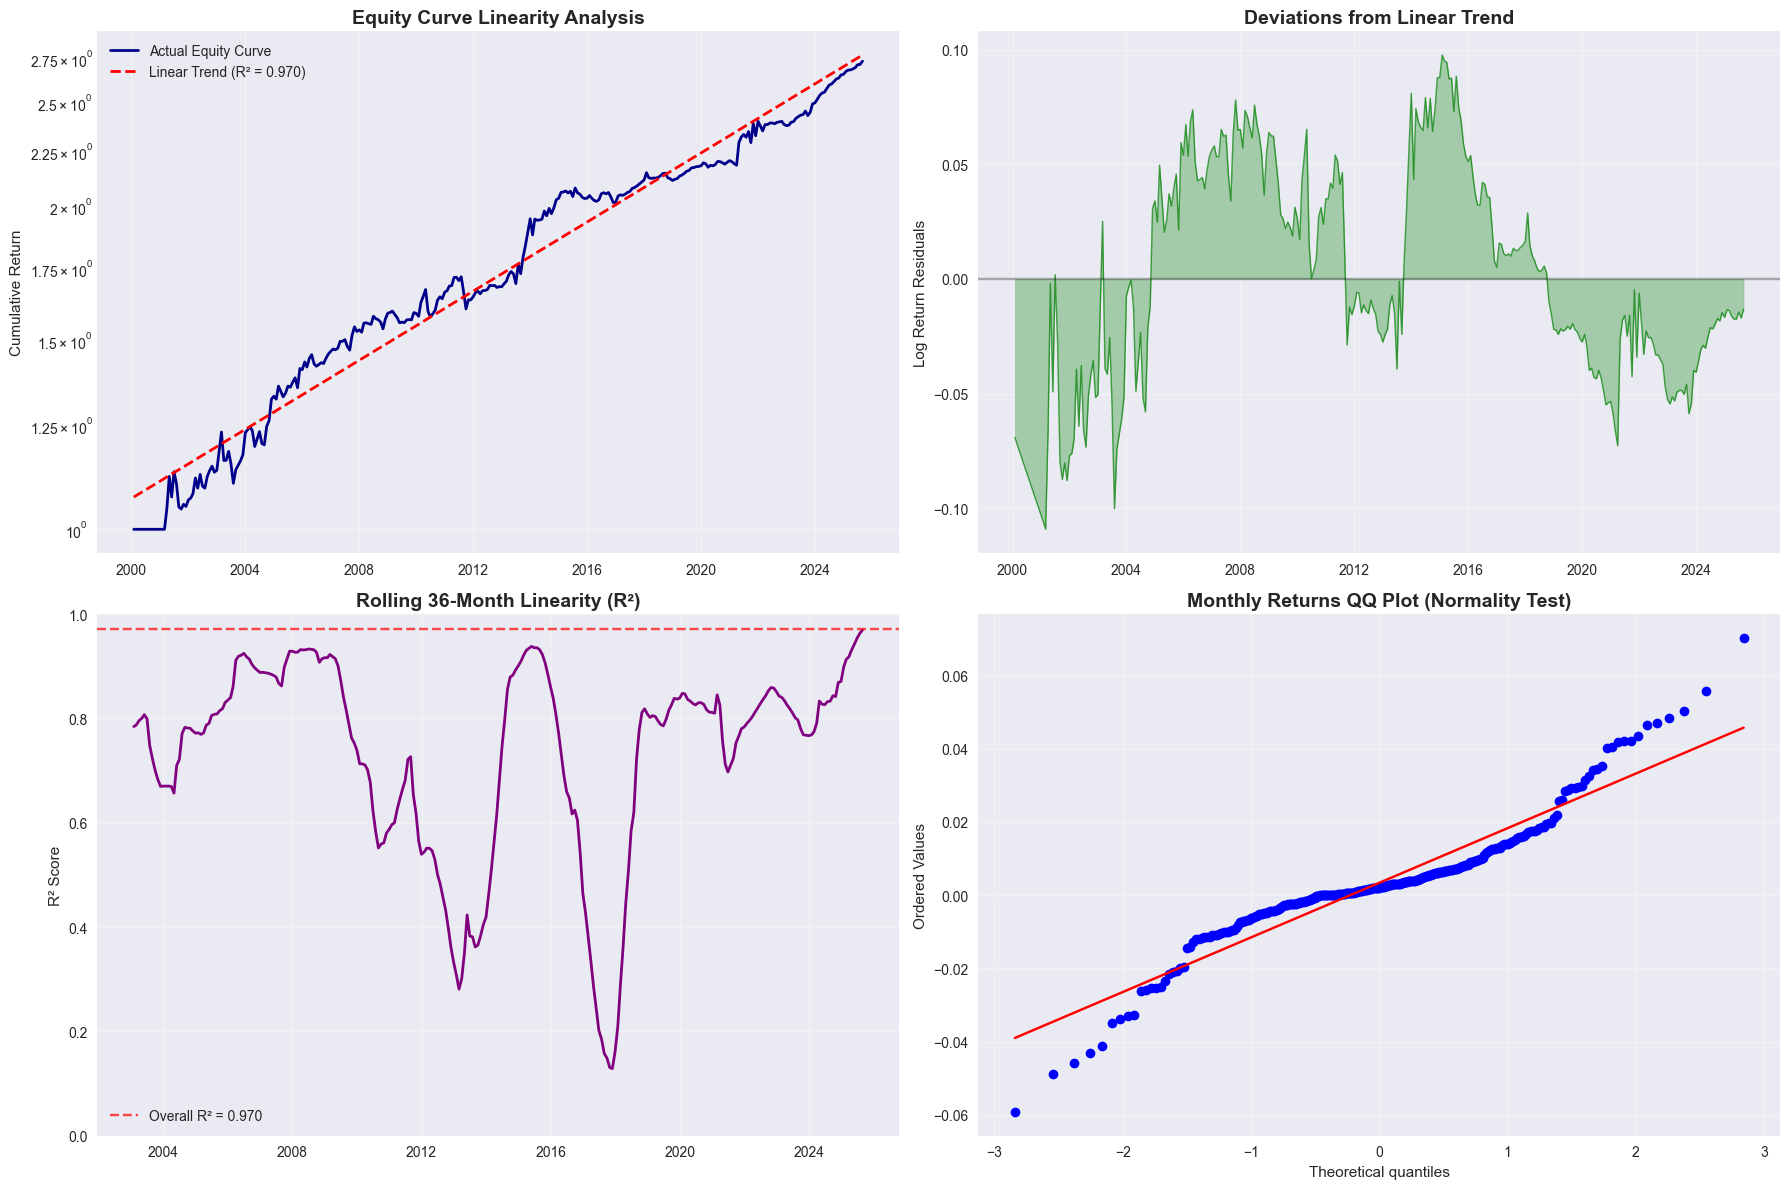

EQUITY CURVE LINEARITY STATISTICS:
Overall R² (goodness of linear fit): 0.9705
Linear trend slope (monthly): 0.003086
Annualized linear growth rate: 0.0370 (3.70%)
Trend volatility (log scale): 0.0479
Mean rolling R² (36-month): 0.7306
Std rolling R² (36-month): 0.1914

NORMALITY TEST (Shapiro-Wilk):
Test statistic: 0.9075
P-value: 0.000000
Returns are not normally distributed (α=0.05)


In [12]:
# Advanced equity curve analysis
portfolio_returns_clean = portfolio_returns.dropna()
portfolio_cumulative_clean = portfolio_cumulative.dropna()

# Create time index for regression analysis
time_index = np.arange(len(portfolio_cumulative_clean))

# === EQUITY CURVE LINEARITY ANALYSIS ===
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Equity curve linearity analysis with R²
log_returns = np.log(portfolio_cumulative_clean)
X = time_index.reshape(-1, 1)
y = log_returns.values

# Linear regression
reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)
r2_score = reg.score(X, y)

# Calculate trend statistics
slope = reg.coef_[0]
annualized_slope = slope * 12  # Convert to annual
trend_volatility = np.std(y - y_pred)

ax1.plot(portfolio_cumulative_clean.index, portfolio_cumulative_clean, 
         linewidth=2, label='Actual Equity Curve', color='darkblue')
ax1.plot(portfolio_cumulative_clean.index, np.exp(y_pred), 
         linewidth=2, linestyle='--', label=f'Linear Trend (R² = {r2_score:.3f})', color='red')
ax1.set_title('Equity Curve Linearity Analysis', fontsize=14, fontweight='bold')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Plot 2: Residuals from linear trend
residuals = y - y_pred
ax2.plot(portfolio_cumulative_clean.index, residuals, linewidth=1, color='green', alpha=0.7)
ax2.axhline(0, color='black', linestyle='-', alpha=0.3)
ax2.fill_between(portfolio_cumulative_clean.index, residuals, 0, alpha=0.3, color='green')
ax2.set_title('Deviations from Linear Trend', fontsize=14, fontweight='bold')
ax2.set_ylabel('Log Return Residuals')
ax2.grid(True, alpha=0.3)

# Plot 3: Linearity metrics over time (rolling R²)
window = 36  # 3 years
rolling_r2 = []
rolling_dates = []

for i in range(window, len(portfolio_cumulative_clean)):
    subset_time = time_index[i-window:i+1].reshape(-1, 1)
    subset_log_returns = log_returns.iloc[i-window:i+1].values
    
    if len(subset_time) > 10:  # Minimum observations
        reg_rolling = LinearRegression().fit(subset_time, subset_log_returns)
        rolling_r2.append(reg_rolling.score(subset_time, subset_log_returns))
        rolling_dates.append(portfolio_cumulative_clean.index[i])

ax3.plot(rolling_dates, rolling_r2, linewidth=2, color='purple')
ax3.axhline(r2_score, color='red', linestyle='--', alpha=0.7, 
           label=f'Overall R² = {r2_score:.3f}')
ax3.set_title(f'Rolling {window}-Month Linearity (R²)', fontsize=14, fontweight='bold')
ax3.set_ylabel('R² Score')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0, 1)

# Plot 4: QQ plot for return normality
stats.probplot(portfolio_returns_clean, dist="norm", plot=ax4)
ax4.set_title('Monthly Returns QQ Plot (Normality Test)', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print linearity statistics
print("EQUITY CURVE LINEARITY STATISTICS:")
print("=" * 50)
print(f"Overall R² (goodness of linear fit): {r2_score:.4f}")
print(f"Linear trend slope (monthly): {slope:.6f}")
print(f"Annualized linear growth rate: {annualized_slope:.4f} ({annualized_slope*100:.2f}%)")
print(f"Trend volatility (log scale): {trend_volatility:.4f}")
print(f"Mean rolling R² ({window}-month): {np.mean(rolling_r2):.4f}")
print(f"Std rolling R² ({window}-month): {np.std(rolling_r2):.4f}")

# Shapiro-Wilk test for normality
shapiro_stat, shapiro_p = stats.shapiro(portfolio_returns_clean)
print(f"\nNORMALITY TEST (Shapiro-Wilk):")
print(f"Test statistic: {shapiro_stat:.4f}")
print(f"P-value: {shapiro_p:.6f}")
print(f"Returns are {'normally' if shapiro_p > 0.05 else 'not normally'} distributed (α=0.05)")